# ARABIC IMAGE CAPTIONING (AIC)
Image captioning refers to the ability of automatically generating a syntactically plausible and semantically meaningful sentence that describes the content of an image. Enabling machines to describe the visual world would result in many advantages, such as improved information retrieval, early childhood education, for visually impaired persons, for social media, and so on. It necessitates skills from the fields of Computer Vision (CV) and Natural Language Processing (NLP).

<img src="images/image_captioning_example.png" alt="image_captioning_example" width="550"/>

Tremendous achievements have been accomplished recently in English Image Captioning, thanks to deep neural networks. Inspired by recent advances in neural machine translation, the sequence-to-sequence encoder-decoder approach was adopted in here, where CNN encoder is utilized to extract image features (image embeddings) and RNN decoder decodes the encoded image features into words.

<img src="images/seq2seq-image-captioning-arabic.png" alt="seq2seq-image-captioning-arabic" width="750"/>

In [ ]:
# run this first if you want to ignore GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm_notebook, tnrange
import keras
from keras_tqdm import TQDMNotebookCallback
print(keras.__version__)
# for arabic text with matplotlib
from bidi import algorithm as bidialg
import arabic_reshaper

Using TensorFlow backend.


2.2.4


**NOTE:** If a module is not installed (e.g., tqdm), you can install it here in a new cell using the **pip** command preceded by exclamation mark (!) as following:

In [ ]:
!pip3 install tqdm

### Define variables
Here, we define some constant variables that we will use later. Variables include the path of the dataset (images & captions) and the path of other important resources such as the pre-trained VGG16 weights and images embeddings (the output of VGG16 (without the last layer) when fed with Flickr8K dataset).

In [2]:
vgg16_weights_path = 'resources/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
images_directory = 'data/Flicker8k_Dataset/'
captions_path = 'data/Flickr8k_text/Flickr8k.token.txt'
arabic_captions_path = 'data/Flickr8k_text/Flickr8k.arabic.txt'
train_path = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
dev_path = 'data/Flickr8k_text/Flickr_8k.devImages.txt'
images_features_path = 'resources/Flickr8K_features.pkl'
image_size = (224, 224) # as recommended by vgg16

images_path = []
images_names = []
captions = {} # dictionary where image name (witout extension) is key and caption is value (here, we use one caption only, not all 5)
captions_file_text = '' # content of the file that contains images names & their captions
vocabulary = [] # list of all unique words in captions

### Transfer Learning
To extract images embeddings using the encoder CNN, we will use VGG16, one of the state-of-the-art models for object detection. This is known as transfer learning, which refers to the situation where what has been learned in one setting (task) is exploited to learn other setting (task). It improve model generalization and fasten training.

We will load the VGG16 model from Keras, load the pre-trianed weights (can be downloaded from [this link](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)), predict on (extarct feature from) Flickr8K images, and finally save extarcted images embeddings to pickle file. Later, we use the extarcted images embeddings (from the pickle file) as input to our model without the need to load VGG16 again. This trick will save us much time, but it has one disadvantage! Fine tuning (re training) the VGG16, which may improve performance, is now not possible!

In [10]:
def load_vgg16(weights_path, print_model_summary=False):
    """load the pre-trained vgg16 model"""
    #load vgg16 model with locally saved weights
    model = keras.applications.vgg16.VGG16(include_top=True, weights=weights_path)
    #remove last layer (fully connected of 1000 neurons) since we are not classifying
    model.layers.pop()
    model = keras.models.Model(inputs=model.inputs, outputs=model.layers[-1].output)
    if print_model_summary: model.summary()
    return model
    

def extract_images_features(img_directory, save_features_to):
    """extract images features using pre-trained vgg16 and save them in a pickle file"""
    features = dict() #to store features from each photo
    #load pre-trained vgg16 model
    pretrained_vgg16 = load_vgg16(vgg16_weights_path, False)
    #get images names
    img_names = os.listdir(img_directory)
    for i in tnrange(len(img_names)):
        #full image path
        img_path = os.path.join(img_directory, img_names[i])
        #load image form file
        img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
        #convert image into numpy array
        img = keras.preprocessing.image.img_to_array(img)
        #reshape image for the model
        img = img.reshape((1,) + img.shape)
        #preprocess image for vgg16
        img = keras.applications.vgg16.preprocess_input(img)
        #get image features
        pred = pretrained_vgg16.predict(img, verbose=0)
        img_name = img_names[i].split('.')[0]
        #store image features
        features[img_name] = pred
    #save image features to pickle file
    pickle.dump(features, open(save_features_to,'wb'))
    print('images features saved to',save_features_to)

extract_images_features(images_directory, images_features_path)


images features saved to AIC/resources/Flickr8K_features.pkl


### Read & visualize dataset

In [59]:
def load_file_text(file_path):
    """reads and returns text in captions file"""
    file = open(file_path, 'r', encoding='utf-8')
    all_text = file.read()
    file.close()
    return all_text

def get_captions(file_text):
    """given file content, returns images names and their captions as dictionary"""
    cpts = {}
    #loop through lines
    for line in file_text.split('\n'): # each line contains image name & its caption separated by tab
        #split by tabs
        img_cpt = line.split('\t')
        if len(img_cpt) < 2: continue
        img, cpt = img_cpt
        #remove image extension & index (remove everything befor the dot)
        img_name = img.split('.')[0]
        #add to dictionary
        if img_name not in cpts:
            cpts[img_name] = cpt
    return cpts

captions_file_text = load_file_text(arabic_captions_path)
captions = get_captions(captions_file_text)
print('Captions #:', len(captions))
print('Caption example:', list(captions.values())[0])

Captions #: 4102
Caption example: طفلة صغيرة تتسلق إلى مسرح خشبي


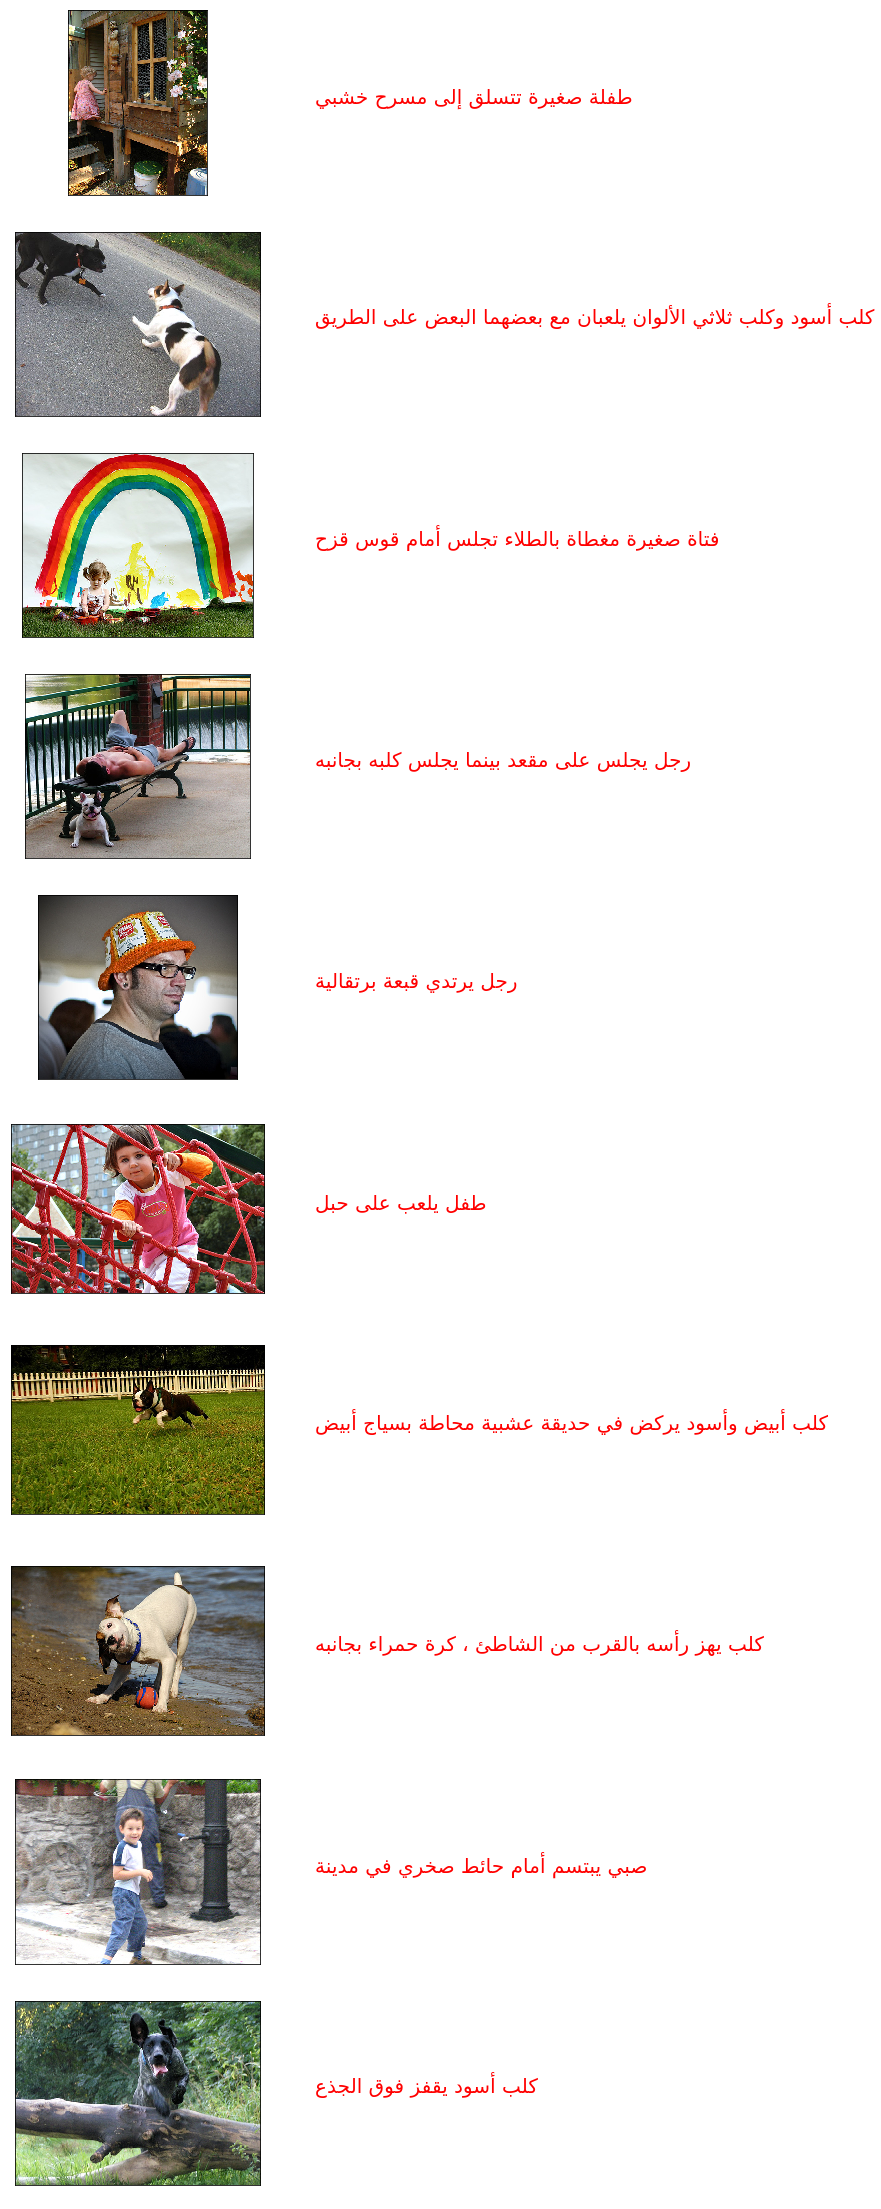

In [60]:
def visualize_images_with_captions(cpts):
    """plot images with their captions"""
    n_pics = len(cpts)
    i = 0
    fig = plt.figure(figsize=(10,n_pics*4))
    #for i,line in enumerate(lines[:n_pics]):
    for img,cpt in cpts.items():
        img_file = img + '.jpg'
        img = keras.preprocessing.image.load_img(images_directory + img_file)
        caption = arabic_reshaper.reshape(cpt)
        caption = bidialg.get_display(caption)
        ax = fig.add_subplot(n_pics,2,2*i+1,xticks=[],yticks=[])
        ax.imshow(img)
        ax = fig.add_subplot(n_pics,2,2*i+2)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.5,caption,fontsize=20,fontdict={'color':  'red','weight': 'normal','size': 14}) #'family': 'serif',
        i += 1

subset = {k:captions[k] for k in list(captions.keys())[:10]}
visualize_images_with_captions(subset)

### Preprocessing & cleaning captions

In [ ]:
from string import punctuation

def preprocess_captions(cpts):
    """ clean captions to reduce vocabulary size we need to work with:
        - lowercase
        - remove punctuations
        - remove one-character words
        - remove words with numbers
    """
    for img, cpt in cpts.items():
        cpt = cpt.lower() #lower case all caption
        cpt = ''.join([c for c in cpt if c not in punctuation]) #remove punctuations
        cpt = ' '.join([w for w in cpt.split() if len(w)>1 and w.isalpha()]) #remove one-character & numeric words
        cpts[img] = cpt
k = '299178969_5ca1de8e40' #2660480624_45f88b3022
print('before >>', captions[k])
preprocess_captions(captions)
print('captions preprocessed :)')
print('after >>', captions[k])

In [4]:
from resources.arabic_preprocessing import Arabic_preprocessing

def preprocess_captions(cpts):
    """ clean captions to get rid of useless textual info & reduce vocabulary size. Preprocessing includes:
        - remove punctuations & diacritics
        - normalize (or standarize) Hamza & Ha2
        - remove repeating characters
        - remove english characters
        - remove one-character words
    """
    process_arab = Arabic_preprocessing()
    for img, cpt in cpts.items():
        processed_caption = process_arab.preprocess_arabic_text(cpt)
        cpts[img] = processed_caption

k = '299178969_5ca1de8e40' #2660480624_45f88b3022
print('before >>', captions[k])
preprocess_captions(captions)
print('captions preprocessed :)')
print('after >>', captions[k])

before >> صبي ,يرتدي اللون الأزرق ,  على الأشجار
captions preprocessed :)
after >> صبي يرتدي اللون الازرق علي الاشجار


In [5]:
%%time
def get_vocabulary(cpts):
    """retruns a list of all unique words in captions"""
    all_captions = ' '.join(list(cpts.values()))
    v = set(all_captions.split())
    return sorted(list(v))

vocabulary = get_vocabulary(captions)
print('Vocabulary size (number of unique words):', len(vocabulary))

Vocabulary size (number of unique words): 3938
Wall time: 7.95 ms


In [6]:
def vocab_counts(cpts, vocab):
    all_captions = ' '.join(list(cpts.values()))
    vocab_dict = {}
    for w in vocab:
        vocab_dict[w] = all_captions.count(w)
    return vocab_dict

def get_word_given_count(vocab_counts, count):
    for k,v in vocab_counts.items():
        if v == count:
            return k

vocabulary_counts = vocab_counts(captions, vocabulary)
max_word_count = max(list(vocabulary_counts.values()))
min_word_count = min(list(vocabulary_counts.values()))
max_word = get_word_given_count(vocabulary_counts, max_word_count)
min_word = get_word_given_count(vocabulary_counts, min_word_count)
print('the word that appeared the most is:', max_word, ' It appeared', max_word_count, 'times')
print('the word that appeared the least is:', min_word, ' It appeared', min_word_count, 'times')

the word that appeared the most is: في  It appeared 1934 times
the word that appeared the least is: ابطال  It appeared 1 times


In [7]:
def add_start_end_to_captions(cpts):
    """precede each caption with <START> and end each caption with <END>"""
    start, end = '<START>', '<END>'
    #start, end = 'start', 'end'
    for k, v in cpts.items():
        cpts[k] = start + ' ' + v + ' ' + end

add_start_end_to_captions(captions)
print(captions[k])

<START> صبي يرتدي اللون الازرق علي الاشجار <END>


In [9]:
# load image embeddings extracted from VGG16 earlier
features = pickle.load(open(images_features_path, 'rb'))

X, y = [], []
for k,v in captions.items():
    if k in features:
        #get input (image features)
        X.append(features[k])
        #get output (image caption)
        y.append(v)

### Tokenize text: convert from text to numbers

In [10]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=len(vocabulary), oov_token='<UNK>', lower=False, filters='')
tokenizer.fit_on_texts(y)
tokenizer.word_index['<PAD>'] = 0
word2index = tokenizer.word_index
index2word = {v:k for k,v in word2index.items()}
max_len = max([len(cpt.split()) for cpt in y])
#tokenize captions
y_tok = tokenizer.texts_to_sequences(y)

In [11]:
print('tokenized caption:', y_tok[0])
print('untokenized caption:', tokenizer.sequences_to_texts([y_tok[0]])[0])

tokenized caption: [2, 205, 32, 257, 23, 1767, 288, 3]
untokenized caption: <START> طفله صغيره تتسلق الي مسرح خشبي <END>


In [12]:
tokenizer.sequences_to_texts([y_tok[0]])[0]

'<START> طفله صغيره تتسلق الي مسرح خشبي <END>'

In [14]:
# split
test_size = 500
X_train = X[:-test_size]
y_train = y_tok[:-test_size]
X_test = X[-test_size:]
y_test = y_tok[-test_size:]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

3601 3601
500 500


In [15]:
def prepare_data_for_model(images_features, cpts, max_len, vocab_size):
    input_image, input_text, output_text = [], [], []
    for img,cpt in zip(images_features,cpts):
        for i in range(1, len(cpt)):
                # split into input and output pair
                in_text, out_text = cpt[:i], cpt[i]
                # pad input sequence
                in_text = keras.preprocessing.sequence.pad_sequences([in_text], maxlen=max_len, padding='post')[0]
                # encode output sequence
                out_text = keras.utils.to_categorical([out_text], num_classes=vocab_size)[0]
                # store
                input_image.append(img)
                input_text.append(in_text)
                output_text.append(out_text)
    return np.array(input_image), np.array(input_text), np.array(output_text)

X_train_image, X_train_text, y_train_text = prepare_data_for_model(X_train, y_train, max_len, len(word2index))
X_train_image = np.squeeze(X_train_image)
print(X_train_image.shape, X_train_text.shape, y_train_text.shape)

X_test_image, X_test_text, y_test_text = prepare_data_for_model(X, y_test, max_len, len(word2index))
X_test_image = np.squeeze(X_test_image)
print(X_test_image.shape, X_test_text.shape, y_test_text.shape)

(28598, 4096) (28598, 26) (28598, 3942)
(4001, 4096) (4001, 26) (4001, 3942)


### Building the model: seq2seq encoder-decoder (with GRU)

In [16]:
class My_Callback(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs):
        logs['BLEU-train'] = self.calculate_bleu(X_train, y_train)
        logs['BLEU-test'] = self.calculate_bleu(X_test, y_test)
        print('BLEU-train:',logs['BLEU-train'],' BLEU-test:',logs['BLEU-test'])
        
    def chop_start_end(self, cpt):
        return cpt.split()[1:-1]
    
    def calculate_bleu(self, X, y):
        bt = []
        for xx,yy in zip(X,y):
            pred = predict_caption(self.model, xx, tokenizer, max_len)
            pred = self.chop_start_end(pred)
            actual = tokenizer.sequences_to_texts([yy])[0]
            actual = self.chop_start_end(actual)
            #print('actual >>',actual)
            #print('pred >>',pred)
            b = sentence_bleu([actual], pred, weights=(1, 0, 0, 0))
            bt.append(b)
        return np.mean(bt)

In [18]:
embeddings_dim = 256
input_image_dim = X_train_image.shape[1]

keras.backend.clear_session()

# image model
input_image = keras.layers.Input(shape=(input_image_dim,), name='input_image')
input_image_dropout = keras.layers.Dropout(0.4)(input_image)
image_embeddings = keras.layers.Dense(embeddings_dim, activation='tanh', name='image_embeddings') (input_image_dropout)

# text model
# Set up the decoder, using `image_embeddings` as initial state.
decoder_inputs = keras.layers.Input(shape=(max_len,))
embeddings = keras.layers.Embedding(len(word2index), embeddings_dim, mask_zero=True)(decoder_inputs)
embeddings_dropout = keras.layers.Dropout(0.4)(embeddings)
gru = keras.layers.GRU(embeddings_dim)(embeddings_dropout, initial_state=image_embeddings) # , return_sequences=True
#flat = keras.layers.Flatten()(gru)
dense = keras.layers.Dense(embeddings_dim, activation='relu')(gru)
decoder_outputs = keras.layers.Dense(len(word2index), activation='softmax')(dense)

seq2seq = keras.Model([input_image, decoder_inputs], decoder_outputs)
seq2seq.summary()

# prepare callback
#histories = My_Callback()

seq2seq.compile(optimizer='adam', loss='categorical_crossentropy')

seq2seq.fit([X_train_image, X_train_text], y_train_text,
            validation_data=([X_test_image, X_test_text], y_test_text),
            batch_size=128,
            epochs=10,
            verbose=2,
            callbacks=[TQDMNotebookCallback()]) # add My_Callback() to callbacks to calculate & display BLEU score after each epoch

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_image (InputLayer)        (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 256)      1009152     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_image[0][0]                
__________________________________________________________________________________________________
dropout_2 

Epoch 1/10


 - 12s - loss: 5.7299 - val_loss: 5.6506
Epoch 2/10


 - 10s - loss: 4.7700 - val_loss: 5.5373
Epoch 3/10


 - 10s - loss: 4.2993 - val_loss: 5.4582
Epoch 4/10


 - 10s - loss: 3.9087 - val_loss: 5.4611
Epoch 5/10


 - 10s - loss: 3.5747 - val_loss: 5.6437
Epoch 6/10


 - 10s - loss: 3.2695 - val_loss: 5.7502
Epoch 7/10


 - 10s - loss: 2.9933 - val_loss: 5.8692
Epoch 8/10


 - 10s - loss: 2.7285 - val_loss: 6.0339
Epoch 9/10


 - 10s - loss: 2.4804 - val_loss: 6.2105
Epoch 10/10


 - 10s - loss: 2.2403 - val_loss: 6.4548



### Predict & Evaluate

In [20]:
def predict_caption(model, images_features, tokenizer, maxlen):
    in_txt = '<START>'
    for word in range(max_len):
        seq = tokenizer.texts_to_sequences([in_txt])[0]
        seq = keras.preprocessing.sequence.pad_sequences([seq], maxlen=maxlen)
        pred = model.predict([images_features, seq], verbose=0)
        pred = np.argmax(pred)
        new_word = index2word[pred]
        in_txt += ' ' + new_word
        if new_word == '<END>':
            #print('I saw END at index',word)
            break
    return in_txt

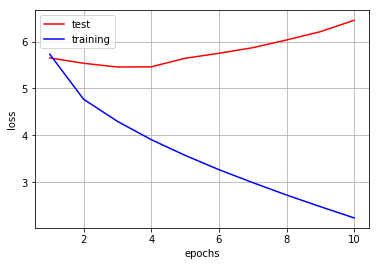

In [21]:
loss_train = seq2seq.history.history['loss']
loss_test = seq2seq.history.history['val_loss']
epochs = seq2seq.history.params['epochs']
epochs = range(1, epochs+1)

plt.plot(epochs, loss_test, 'r', label='test')
plt.plot(epochs, loss_train, 'b', label='training')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

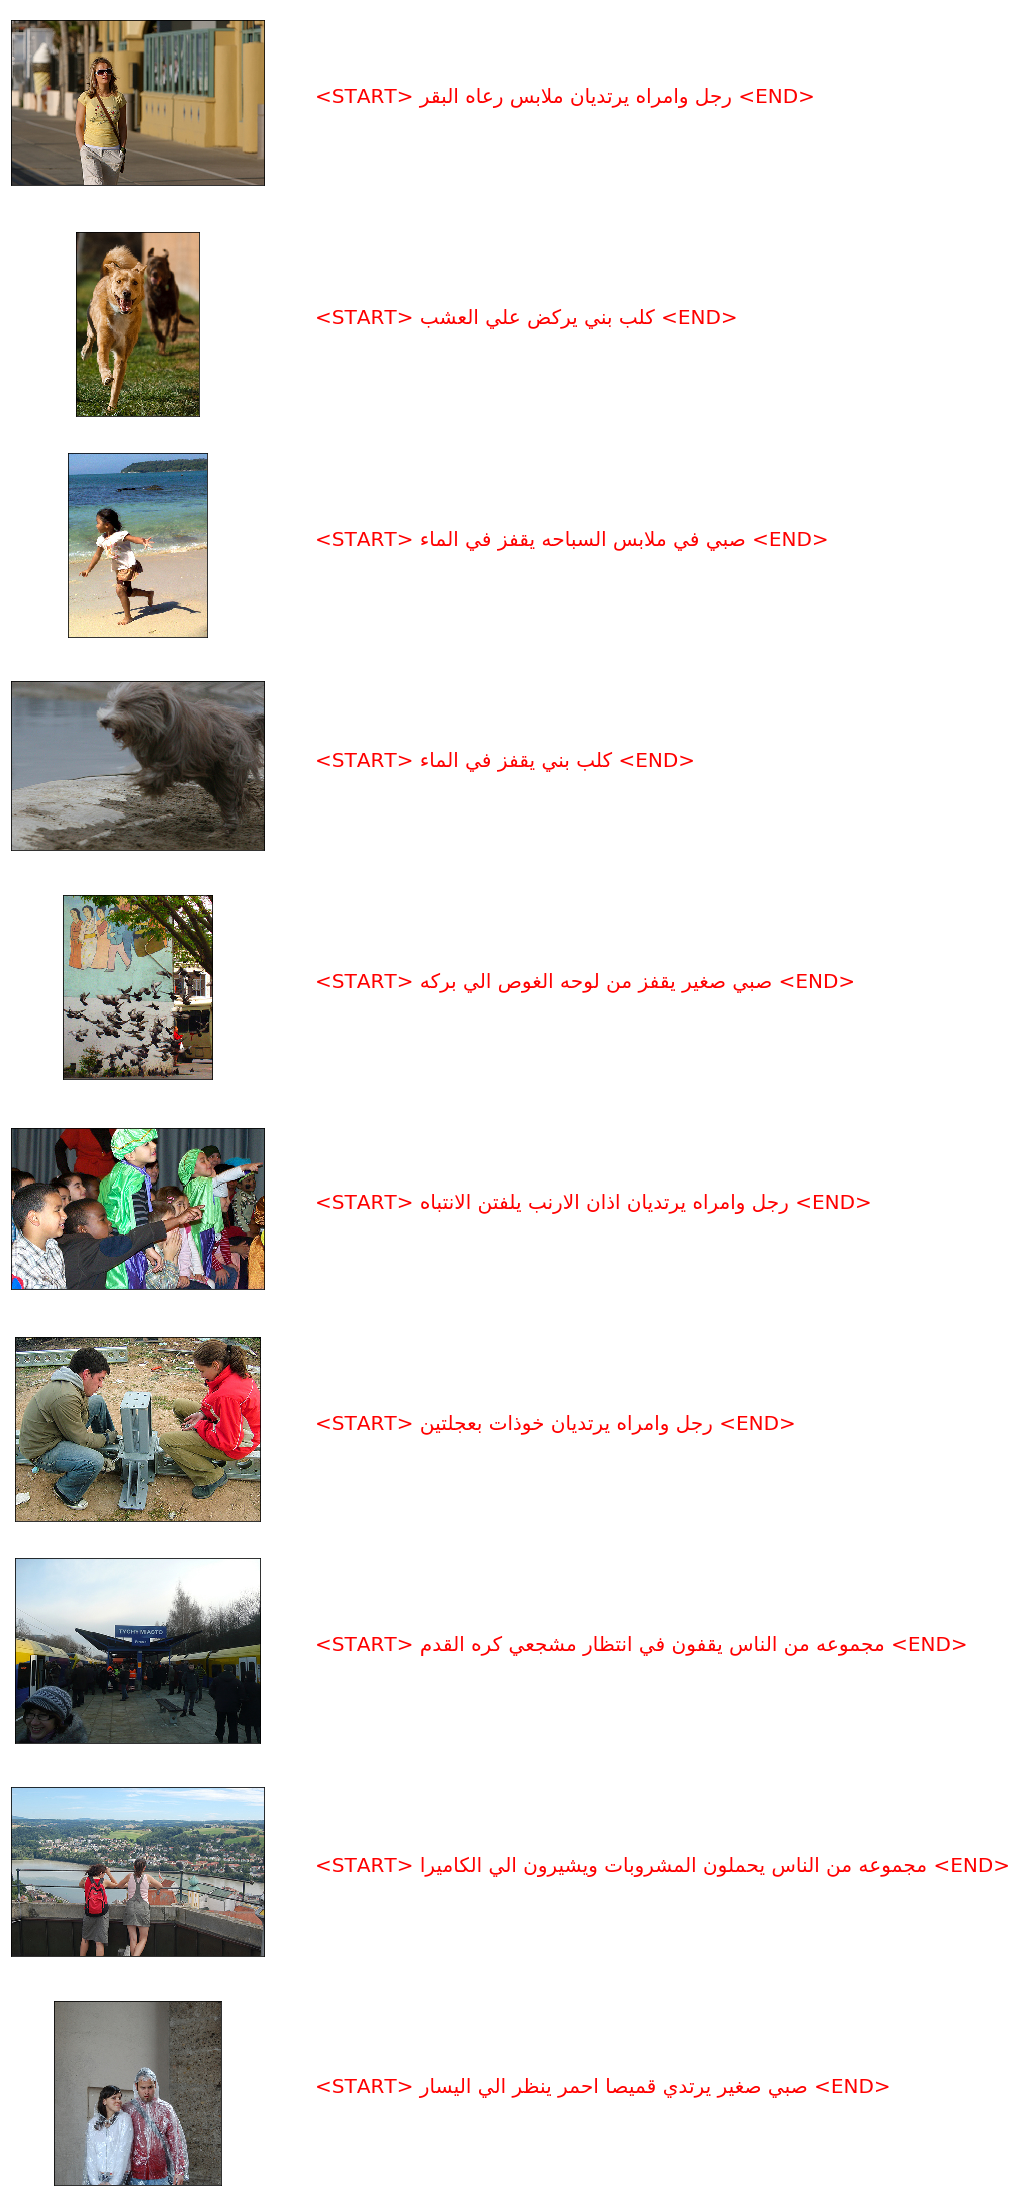

In [61]:
subset = {k:captions[k] for k in list(captions.keys())[-10:]}
pred = {}
for k,v in subset.items():
    cpt = predict_caption(seq2seq, features[k], tokenizer, max_len)
    pred[k] = cpt
visualize_images_with_captions(pred)

#good = [9, 10, 15, 18]
#bad = [21, 22, 29]

In [44]:
def chop_start_end(cpt):
    if cpt.startswith('<START>') and cpt.endswith('<END>'):
        cpt = ' '.join(cpt.split()[1:-1])
    return cpt

def BLEU_score(model, X, y):
    b1,b2,b3,b4 = [],[],[],[]
    for xx,yy in zip(X,y):
        ref = tokenizer.sequences_to_texts([yy])[0]
        ref = [chop_start_end(ref).split()]
        pred = predict_caption(model, xx, tokenizer, max_len)
        pred = chop_start_end(pred).split()
        b1.append(sentence_bleu(ref, pred, weights=(1, 0, 0, 0)))
        b2.append(sentence_bleu(ref, pred, weights=(0.5, 0.5, 0, 0)))
        b3.append(sentence_bleu(ref, pred, weights=(1/3, 1/3, 1/3, 0)))
        b4.append(sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25)))
    return np.mean(b1), np.mean(b2), np.mean(b3), np.mean(b4)

In [50]:
b1_train,b2_train,b3_train,b4_train = BLEU_score(seq2seq, X_train, y_train)
b1_test,b2_test,b3_test,b4_test = BLEU_score(seq2seq, X_test, y_test)

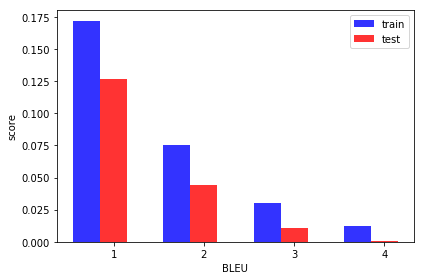

In [41]:
def plot_bleu_bar_graph(bleu_train, bleu_test):
    n_groups = 4
    #bleu_train = (b1_train,b2_train,b3_train,b4_train)
    #bleu_test = (b1_test,b2_test,b3_test,b4_test)
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.3
    opacity = 0.8

    rects1 = plt.bar(index, bleu_train, bar_width,
                     alpha=opacity,
                     color='b',
                     label='train')

    rects2 = plt.bar(index + bar_width, bleu_test, bar_width,
                     alpha=opacity,
                     color='r',
                     label='test')

    plt.xlabel('BLEU')
    plt.ylabel('score')
    #plt.title('Scores')
    plt.xticks(index + bar_width, ('1', '2', '3', '4'))
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_bleu_bar_graph((b1_train,b2_train,b3_train,b4_train), (b1_test,b2_test,b3_test,b4_test))

### Merge Model

In [43]:
embeddings_dim = 256
input_image_dim = X_train_image.shape[1]

# feature extractor model
inputs1 = keras.layers.Input(shape=(input_image_dim,))
fe1 = keras.layers.Dropout(0.3)(inputs1)
fe2 = keras.layers.Dense(embeddings_dim, activation='relu')(fe1)
# sequence model
inputs2 = keras.layers.Input(shape=(max_len,))
se1 = keras.layers.Embedding(len(word2index), embeddings_dim, mask_zero=True)(inputs2)
se2 = keras.layers.Dropout(0.3)(se1)
se3 = keras.layers.LSTM(embeddings_dim)(se2)
# decoder model
decoder1 = keras.layers.merge.add([fe2, se3])
decoder2 = keras.layers.Dense(embeddings_dim, activation='relu')(decoder1)
outputs = keras.layers.Dense(len(word2index), activation='softmax')(decoder2)
# tie it together [image, seq] [word]
merge_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
# compile model
merge_model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
merge_model.summary()
#plot_model(model, to_file='others/merge_model.png', show_shapes=True)

merge_model.fit([X_train_image, X_train_text], y_train_text,
          validation_data=([X_test_image, X_test_text], y_test_text),
          batch_size=128,
          epochs=10,
          verbose=2,
          callbacks=[TQDMNotebookCallback()])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 256)      1009152     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_4 

Epoch 1/10


 - 13s - loss: 5.7281 - val_loss: 5.9763
Epoch 2/10


 - 11s - loss: 4.7154 - val_loss: 6.0432
Epoch 3/10


 - 11s - loss: 4.1013 - val_loss: 6.3615
Epoch 4/10


 - 11s - loss: 3.5982 - val_loss: 6.6209
Epoch 5/10


 - 12s - loss: 3.1089 - val_loss: 7.0784
Epoch 6/10


 - 11s - loss: 2.6512 - val_loss: 7.5400
Epoch 7/10


 - 11s - loss: 2.2592 - val_loss: 7.8438
Epoch 8/10


 - 11s - loss: 1.9388 - val_loss: 8.1438
Epoch 9/10


 - 11s - loss: 1.6823 - val_loss: 8.4350
Epoch 10/10


 - 11s - loss: 1.4719 - val_loss: 8.6376



In [45]:
b1_train,b2_train,b3_train,b4_train = BLEU_score(merge_model, X_train, y_train)
b1_test,b2_test,b3_test,b4_test = BLEU_score(merge_model, X_test, y_test)

c:\python\python36\coding4fun\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python36\coding4fun\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python36\coding4fun\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

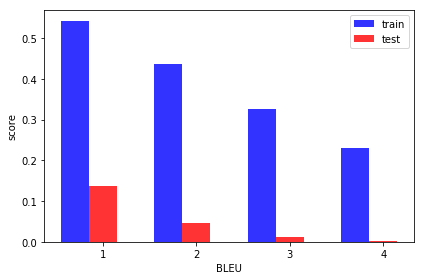

In [46]:
plot_bleu_bar_graph((b1_train,b2_train,b3_train,b4_train), (b1_test,b2_test,b3_test,b4_test))

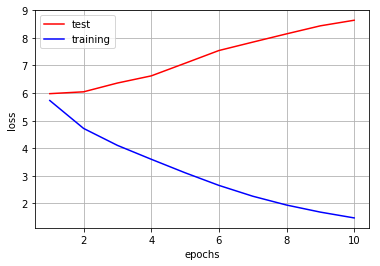

In [47]:
loss_train = merge_model.history.history['loss']
loss_test = merge_model.history.history['val_loss']
epochs = merge_model.history.params['epochs']
epochs = range(1, epochs+1)

plt.plot(epochs, loss_test, 'r', label='test')
plt.plot(epochs, loss_train, 'b', label='training')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

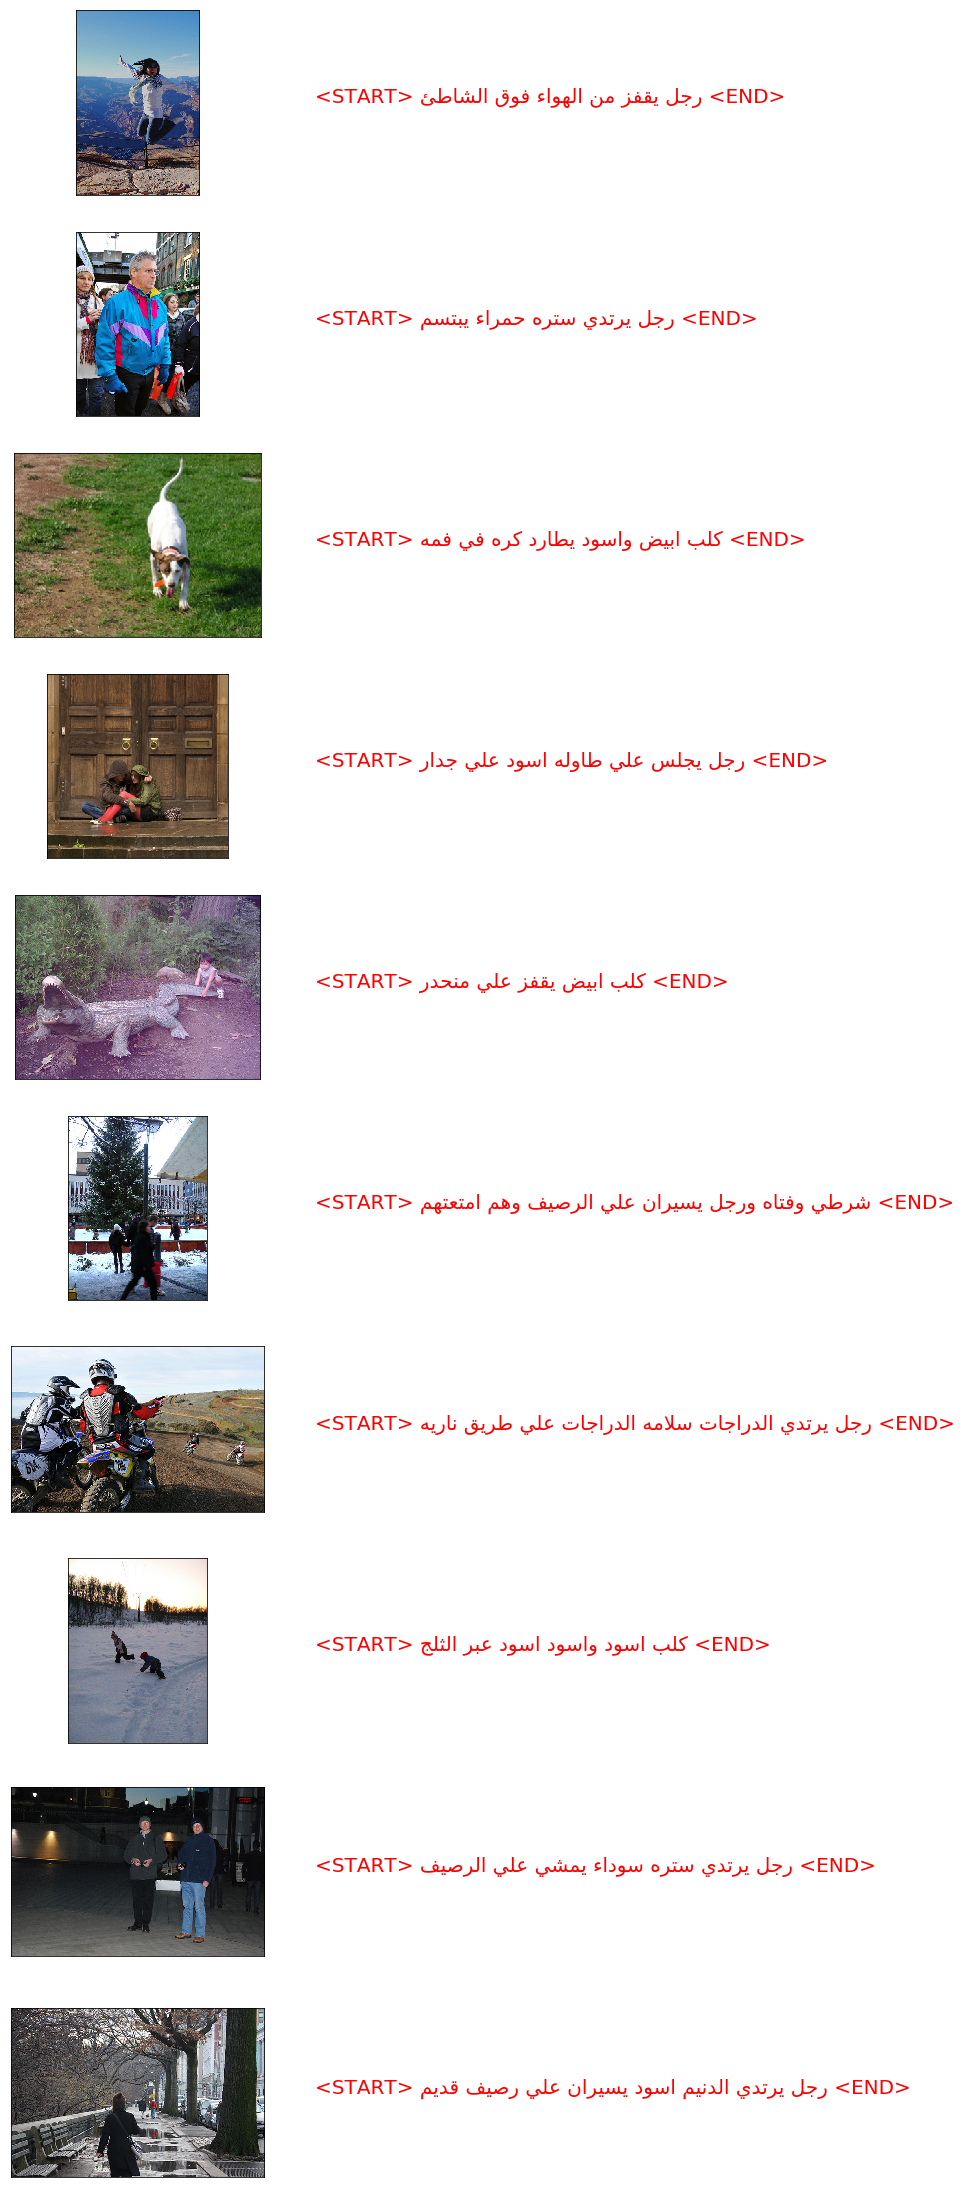

In [63]:
subset = {k:captions[k] for k in list(captions.keys())[-30:-20]}
#img_features = [features[k] for k,v in subset.items()]
pred = {}
for k,v in subset.items():
    cpt = predict_caption(merge_model, features[k], tokenizer, max_len)
    pred[k] = cpt
visualize_images_with_captions(pred)